<a href="https://colab.research.google.com/github/gilsalvans/DSSG_SS2021/blob/main/Donike_Salvans_DSSG_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assessing bias and fairness in the COMPAS Recidivism Risk dataset: Study case for Age and Race
This notebook's workflow is the following:
- Import Adult dataset -> COMPAS data & check basic structure
- Study case 1: Assessing bias/fairness per Race: <br>
    - Variable Analysis
    - Bias and Faireness audit with Aequitas
- Study case 2: Assessing bias/fairness per Age Group:<br>
    - Variable Analysis
    - Bias and Faireness audit with Aequitas

In [ ]:
#imports
import google.colab
import pandas as pd
import numpy as np
import seaborn as sns
import functools
import matplotlib.pyplot as plt
!pip install aequitas
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap
!pip install --upgrade witwidget

In [2]:
# Reading data from our repository
raw_df = pd.read_csv('https://raw.githubusercontent.com/gilsalvans/DSSG_SS2021/main/data/compas-scores-two-years.csv')
raw_df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,14001422CF10A,2014-01-31,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-02-01,Risk of Violence,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:01,2014-01-14 07:49:46,14000581CF10A,2014-01-13,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-01-14,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,0,2,0,0,3,-1.0,2014-03-08 08:06:02,2014-03-09 12:18:04,140033

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

Since the aim of this assignment is not to carry out a full machine learning pipeline, but to assess bias and faireness of already processed & classified data, the pre-processed dataset will subsequently be imported.

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/gilsalvans/DSSG_SS2021/main/data/compas_processed_aequitas.csv')
df

,entity_id,score,label_value,race,sex,age_cat
0,1,0.0,0,Other,Male,Greater than 45
1,3,0.0,1,African-American,Male,25 - 45
2,4,0.0,1,African-American,Male,Less than 25
3,5,1.0,0,African-American,Male,Less than 25
4,6,0.0,0,Other,Male,25 - 45
...,...,...,...,...,...,...
7209,10996,1.0,0,African-American,Male,Less than 25
7210,10997,0.0,0,African-American,Male,Less than 25
7211,10999,0.0,0,Other,Male,Greater than 45
7212,11000,0.0,0,African-American,Female,25 - 45


Since the attributes to be assessed will be race and age category, these can be taken out from the processed dataframe. Therefore, one dataframe with age category and one with race are created for the subsequent analysis. Score refers to the classification output and label value to the supervised label for the classification (these will be subsequently explained in the analysis).

In [5]:
#race & age dataframes
df_race = df[['entity_id', 'score', 'label_value', 'race']]
df_age = df[['entity_id', 'score', 'label_value', 'age_cat']]

#Study Case 1: Bias/Fairness assessment for Race 
This first section focuses on assessing prediction bias on recidivism risk using race as input variable. Racial group is a clear attribute, in which in case of bias, the fairness of the model could be very questionable. According to this, race is an important attribute to analyze its implications on the predictions.
Therefore, its structure will start from an analysis of this variable to an assessment using the Aequitas Python library.

In [6]:
#race variable analysis
race_classes = df_race['race'].unique().tolist()
print('There are ', len(race_classes) , 'different race classes in dataset')
race_classes

There are  6 different race classes in dataset


['Other',
 'African-American',
 'Caucasian',
 'Hispanic',
 'Native American',
 'Asian']

In [7]:
df_race['race'].value_counts()

African-American    3696
Caucasian           2454
Hispanic             637
Other                377
Asian                 32
Native American       18
Name: race, dtype: int64

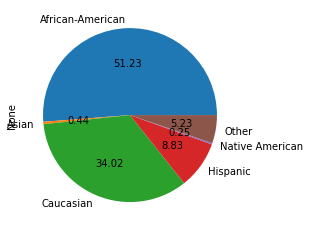

In [8]:
df_race.groupby('race').size().plot(kind='pie', autopct='%.2f')

In [9]:
#plot palette definition
aq_palette = sns.diverging_palette(225, 35, n=2)

Note: This plot takes the count per class into account.


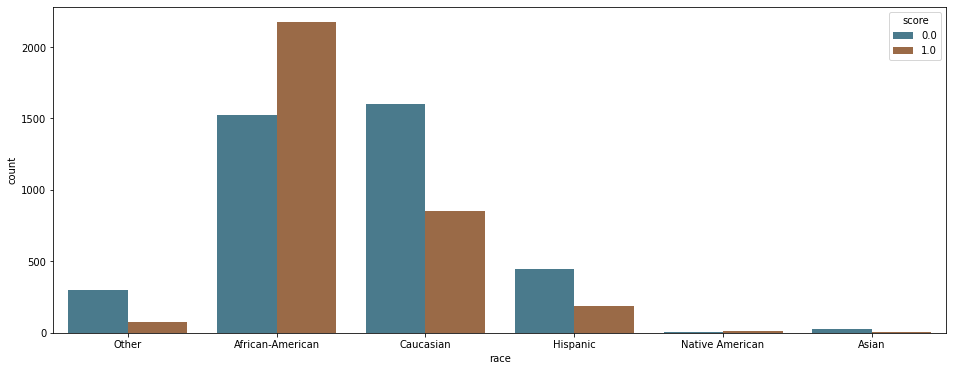

In [10]:
#score plot
plt.figure(figsize=(16,6))
by_race = sns.countplot(x="race", hue="score", data=df_race[df_race.race.isin(['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Other', 'Native American'])], palette=aq_palette)
print('Note: This plot takes the count per class into account.')

First of all, this plot refers to the predicted risk score with explanation on the note below. As the plot shows, the African-American ethnical group have significantly higher predicted scores than the other groups. Most of the racial groups have higher number of people with score 0, except for African-American and Native American. <br> <br>
<b>Note: </b>COMPAS produces a risk score that predicts a person's likelihood of commiting a crime in the next two years. The output is a score between 1 and 10 that maps to low, medium or high. For Aequitas, we collapse this to a binary prediction. A score of 0 indicates a prediction of "low" risk according to COMPAS, while a 1 indicates "high" or "medium" risk (DSSG documentation). 

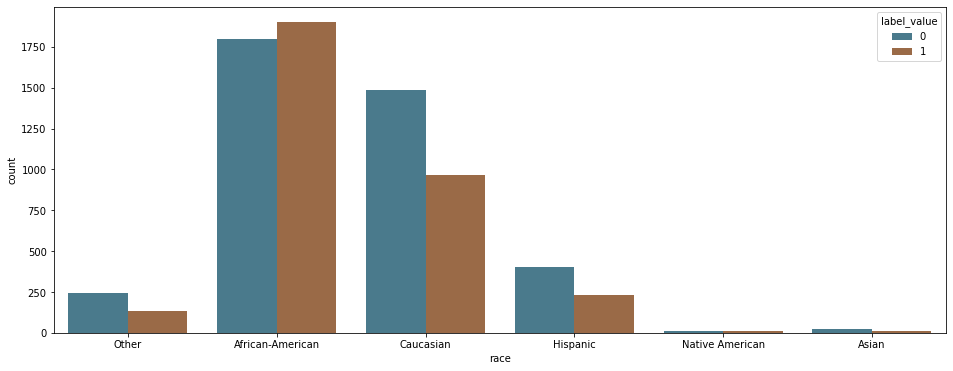

In [11]:
#level of recidivism plot
plt.figure(figsize=(16,6))
label_by_race = sns.countplot(x="race", hue="label_value", data=df_race[df_race.race.isin(['Caucasian', 'African-American', 'Asian', 'Hispanic', 'Other', 'Native American'])], palette=aq_palette)

Label value corresponds to recidivism and it refers to the new arrest within two years. If the label is 1, there is a new arrest within 2 years, if not, label is 0. <br>
This attribute, as mentioned, is used to supervise the risk score predictions and test its accuracy.
Therefore, the results obviously match with the risk score chart, by having African-Americans tending to be more labelled with a positive recidivism value.

In [12]:
race = df_race['race'].tolist()
score = df_race['score'].tolist()
recividism = df_race['label_value'].tolist()

def CountScoreClasses(race_class, column):
  count = 0
  count2 = 0

  for i in range(len(df)):
    if race[i] == race_class and column[i] == 1:
      count += 1
    elif race[i] == race_class and column[i] == 0:
      count2 += 1

  return count, count2

In [13]:
#counting score per race
afr_am_sc = CountScoreClasses('African-American', score)
caucasian_sc = CountScoreClasses('Caucasian', score)
asian_sc = CountScoreClasses('Asian', score)
native_am_sc = CountScoreClasses('Native American', score)
hispanic_sc = CountScoreClasses('Hispanic', score)
other_sc = CountScoreClasses('Other', score)

In [14]:
#counting recividism per race
afr_am_rec = CountScoreClasses('African-American', recividism)
caucasian_rec = CountScoreClasses('Caucasian', recividism)
asian_rec = CountScoreClasses('Asian', recividism)
native_am_rec = CountScoreClasses('Native American', recividism)
hispanic_rec = CountScoreClasses('Hispanic', recividism)
other_rec = CountScoreClasses('Other', recividism)

In [15]:
#prepare precentage df columns 
score1 = [other_sc[0], afr_am_sc[0], caucasian_sc[0], hispanic_sc[0], native_am_sc[0], asian_sc[0] ]
score0 = [other_sc[1], afr_am_sc[1], caucasian_sc[1], hispanic_sc[1], native_am_sc[1], asian_sc[1] ]

rec1 = [other_rec[0], afr_am_rec[0], caucasian_rec[0], hispanic_rec[0], native_am_rec[0], asian_rec[0] ]
rec0 = [other_rec[1], afr_am_rec[1], caucasian_rec[1], hispanic_rec[1], native_am_rec[1], asian_rec[1] ]

cols = {'race' : race_classes, 'score0' : score0, 'score1' : score1, 'rec0' : rec0, 'rec1' : rec1}
df_percent_race = pd.DataFrame(data=cols)

In [16]:
#calculate % of variables
percentage_sc0 = []
percentage_sc1 = []

percentage_rec0 = []
percentage_rec1 = []

for i in range(len(df_percent_race)):
  value_sc1 = (score1[i] * 100)/(score0[i] + score1[i])
  value_sc0 = (score0[i] * 100)/(score1[i] + score0[i])
  value_rec1 = (rec1[i] * 100)/(rec0[i] + rec1[i])
  value_rec0 = (rec0[i] * 100)/(rec1[i] + rec0[i])
  percentage_sc0.append(value_sc0)
  percentage_sc1.append(value_sc1)
  percentage_rec0.append(value_rec0)
  percentage_rec1.append(value_rec1)

df_percent_race['%_score0'] = percentage_sc0
df_percent_race['%_score1'] = percentage_sc1
df_percent_race['%_rec0'] = percentage_rec0
df_percent_race['%_rec1'] = percentage_rec1

df_percent_race

,race,score0,score1,rec0,rec1,%_score0,%_score1,%_rec0,%_rec1
0,Other,298,79,244,133,79.045093,20.954907,64.721485,35.278515
1,African-American,1522,2174,1795,1901,41.179654,58.820346,48.566017,51.433983
2,Caucasian,1600,854,1488,966,65.199674,34.800326,60.635697,39.364303
3,Hispanic,447,190,405,232,70.172684,29.827316,63.579278,36.420722
4,Native American,6,12,8,10,33.333333,66.666667,44.444444,55.555556
5,Asian,24,8,23,9,75.000000,25.000000,71.875000,28.125000


The main observed disparities in the dataset are that African-American and Native Americans have the highest proportion of higher risk score and recividism. So, they have the labelled highest reincidence risk. With this, it is now time to further with the bias assessment of the predictions using Aequitas.

<b> Note: <b> The code from the Aequitas tool has been reused from the COMPAS notebook: https://colab.research.google.com/github/dssg/aequitas/blob/update_compas_notebook/docs/source/examples/compas_demo.ipynb#scrollTo=201dYvnoRGWG

In [ ]:
#define df with variables to audit
g = Group()
xtab, _ = g.get_crosstabs(df_race)
absolute_metrics = g.list_absolute_metrics(xtab)

In [18]:
#indicators to take into account for further figures
metrics = ['fpr','fdr', 'fnr']
disparity_tolerance = 1.25

In [19]:
# Compute Group Counts bias metrics
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,3317,race,African-American,2174,1522,805,532,990,1369,1901,1795,3696,7214
1,0,binary 0/1,3317,race,Asian,8,24,2,3,21,6,9,23,32,7214
2,0,binary 0/1,3317,race,Caucasian,854,1600,349,461,1139,505,966,1488,2454,7214
3,0,binary 0/1,3317,race,Hispanic,190,447,87,129,318,103,232,405,637,7214
4,0,binary 0/1,3317,race,Native American,12,6,3,1,5,9,10,8,18,7214
5,0,binary 0/1,3317,race,Other,79,298,36,90,208,43,133,244,377,7214


For a better understanding and interpretation, the group value bias metrics is computed below.

In [20]:
# Group value bias metrics
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,race,African-American,0.72,0.55,0.35,0.37,0.45,0.28,0.65,0.63,0.66,0.59,0.51
1,race,Asian,0.67,0.91,0.12,0.25,0.09,0.33,0.88,0.75,0.00,0.25,0.28
2,race,Caucasian,0.52,0.77,0.29,0.41,0.23,0.48,0.71,0.59,0.26,0.35,0.39
3,race,Hispanic,0.44,0.79,0.29,0.46,0.21,0.56,0.71,0.54,0.06,0.30,0.36
4,race,Native American,0.90,0.62,0.17,0.25,0.38,0.10,0.83,0.75,0.00,0.67,0.56
5,race,Other,0.32,0.85,0.30,0.46,0.15,0.68,0.70,0.54,0.02,0.21,0.35


According to the provided table above, African-American, followed by Native American, are by far the racial groups with higher False Positive Rate (45% and 38% respectively). Therefore, the model tents to wrongly label these two ethnical groups as high risk, especially the African-Americans. On the other side, Caucasian and Other are the least affected when it comes to positive wrongly labelling (fpr rate of 21% and 15% respectively). <br>
Regarding false negative rates (rate of negatives who should have been classified as positive), the Caucasian group is again in a privileged position with a significantly high false negative rate of 48% - also with Hispanic (56%) and Other (68%)-. On the other side, the least false negatives fall on the groups of Native American (10%) and African-American (28%). <br> 
For a more visual understanding, a plot referring bias absolute metrics taking into reference the Caucasian is computed below. <br> Note: It is just a reference, since the graph is absolute. In the disparities, the most "privileged" races in the model will be compared; Hispanic and Caucasian.


In [22]:
#absolute metrics plot - reference Caucasian
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_race, 
                                        ref_groups_dict={'race':'Caucasian'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)

ap.absolute(bdf, metrics, 'race', fairness_threshold = disparity_tolerance)

get_disparity_predefined_group()


alt.LayerChart(...)

As shown in this Absolute values by Race plot, African American and Native American have clear divergent values in FPR and FNR. Nevertheless, the false discovery rate (FDR) is very similar.

After looking at the bias absolute metrics, it is time to compute the bias disparity levels. These, will be in accordance with the absolute metrics values and as mentioned, they will be computed taking Caucasian and Hispanic as reference groups (they seem to be the most privileged groups in the previous values).

In [23]:
#bias disparity 
#b = Bias()

#putting disparity to compare to Caucasian
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_race, 
                                        ref_groups_dict={'race':'Caucasian'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

get_disparity_predefined_group()


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,race,African-American,0.906085,0.586416,1.213154,1.912093,0.913728,2.545667,1.690224,1.064904,0.720526,1.377549,True,True,False,True,True,False,True,True,True,False,False,True
1,race,Asian,0.611748,0.698482,0.433839,0.370749,1.229148,0.009368,0.718384,1.268317,1.192808,1.275248,False,False,False,False,False,False,False,False,False,False,False,False
2,race,Caucasian,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
3,race,Hispanic,1.120464,1.165140,1.001616,0.915887,0.999346,0.222482,0.857099,0.916748,1.025773,0.849249,False,True,False,False,False,False,False,True,True,False,False,False
4,race,Native American,0.611748,0.209544,0.578453,1.598854,1.170618,0.014052,1.915691,1.268317,0.816506,1.721584,False,True,False,False,False,False,False,True,True,False,False,False
5,race,Other,1.115085,1.417970,1.048203,0.629057,0.980490,0.092506,0.602147,0.920466,1.113660,0.618447,False,True,False,False,False,False,False,True,True,False,False,False


As stated, the first reference group for comparing disparities is Caucasian. As the table shows, the higher and lower disparity rates are in accordance with the previous absolute metrics. Like previously, the fpr and fnr have clear disparities between Caucasian and African-American/Native American. These last two groups have a much higher number of persons being falsely classified as medium or high risks; 1.9 times more for African-Americans and 1.59 times more for Native Americans. <br>
To make it more visual, some graphical figures will be subsequently plotted.

In [24]:
#plotting disparities using the previous reference indicators
ap.disparity(bdf, metrics, 'race', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

Disparities for Hispanic are now computed.

In [25]:
#putting disparity to compare to Hispanic
bdf_hispanic = b.get_disparity_predefined_groups(xtab, original_df=df_race, 
                                        ref_groups_dict={'race':'Hispanic'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf_hispanic[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf_hispanic) + b.list_significance(bdf_hispanic)].style

get_disparity_predefined_group()


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,race,African-American,0.808669,0.503301,1.211197,2.087696,0.914326,11.442105,1.972030,1.161610,0.702423,1.622079,True,True,True,True,True,True,True,True,True,True,True,True
1,race,Asian,0.545977,0.599483,0.433140,0.404798,1.229953,0.042105,0.838158,1.383495,1.162838,1.501618,False,False,False,False,False,False,False,False,False,False,False,False
2,race,Caucasian,0.892487,0.858266,0.998387,1.091838,1.000654,4.494737,1.166727,1.090812,0.974874,1.177511,False,True,False,False,False,False,False,True,True,False,False,False
3,race,Hispanic,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
4,race,Native American,0.545977,0.179845,0.577519,1.745690,1.171384,0.063158,2.235088,1.383495,0.795991,2.027184,False,True,False,False,False,False,False,True,True,False,False,False
5,race,Other,0.995199,1.216996,1.046512,0.686829,0.981132,0.415789,0.702541,1.004056,1.085679,0.728228,False,True,False,False,False,False,False,True,True,False,False,False


In [26]:
#plotting disparities using the previous reference indicators - Hispanic
ap.disparity(bdf_hispanic, metrics, 'race', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

For Hispanic, the disparity level in the FPR compared to African-American and Native American groups is even bigger. This means that the African-Americans tent to be classified as medium-high risk 2.09 times more than the Hispanics. Or the Native Americans 1.75 times more than this reference race. This shows clear bias and unfairness from these resulted predictions. <br>
As a last step for this variable analysis, it is time to run fairness parity tests.

In [27]:
#Summary  - Parity Test
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

The attribute race fails the parity test, by taking the Caucasian group as reference. This, as the note in the chart shows, means that the disparities of race in the evaluated indicators (fpr, fdr, fnr) are higher than the set treshold (standard according to the documentation). Therefore, the model is clearly bias for this racial attribute. <br>
Note: The same test is not computed for Hispanic since, as shown before, the values are even more bias and it would obviously be a fail for the three indicators.



Finally, it is time to assess the attribute fairness (race) and the overall fairness.

In [28]:
# Attribute fairness - by race
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [29]:
race_fairness = f.get_group_attribute_fairness(fdf)
race_fairness

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,race,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False


As this table above shows, all the parity tests calculated on the bias indicators fail, except for the Negative Predicted Value parity. This last value does not take any relevant role in the assessment if all the others have disparities like it shows. 

In [30]:
overall_fair = f.get_overall_fairness(fdf)
overall_fair

{'Overall Fairness': False,
 'Supervised Fairness': False,
 'Unsupervised Fairness': False}

Therefore, these predictions are completely unfair, especially to the ethnical groups African American and Native American. 

#Study Case 2: Bias/Fairness assessment for Age categories
For the second case, the age parameter is examined. The age is an important metric when appeal courts look at wether a certain individual should be freed or not. It is known and clear that younger criminals tend to re-offend, while older individuals are more risk-averse and therefore end up back in prison at a lower rate. (https://www.ussc.gov/research/research-reports/effects-aging-recidivism-among-federal-offenders#:~:text=Older%20offenders%20were%20substantially%20less,at%20the%20time%20of%20release.)

People younger than 21 actually have a likelihood of 2/3 to end up back in prison, while people over 65 only have a chance of 14% to re-offend.

While the case for age discrimination might be made, society in general seems to agree that younger criminials need a tougher sentence as a warning, while older, more settled offenders might be given a second chance. Age itself is, unlike other catogeries such as gender or race, the same for every human being. Every person of every race and every gender is "young" once and (hopefully) "old" later on in their lives, therefore it is not necissarily discriminatory to keep younger criminals in prison for longer.

For this analysis, the same workflow as for the race parameter is followed and examined. The same age categories as in the dataset were used, since the original ages of the persons is not included in the aequitas dataset. 


## 1. Data Analysis

In [31]:
#age variable analysis
df_age = df[['entity_id', 'score', 'label_value', 'age_cat']]
age_classes = df_age['age_cat'].unique().tolist()
print('There are ', len(age_classes) , 'different race classes in dataset')
age_classes

There are  3 different race classes in dataset


['Greater than 45', '25 - 45', 'Less than 25']

In [32]:
df_age['age_cat'].value_counts()

25 - 45            4109
Greater than 45    1576
Less than 25       1529
Name: age_cat, dtype: int64

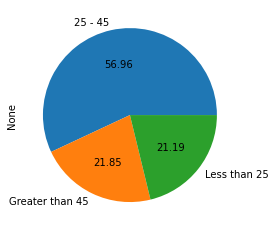

In [33]:
df_age.groupby('age_cat').size().plot(kind='pie', autopct='%.2f')

## 2. Absolute number of predicted reoffenders by age group vs. actual number

Note: This plot takes the count per class into account.


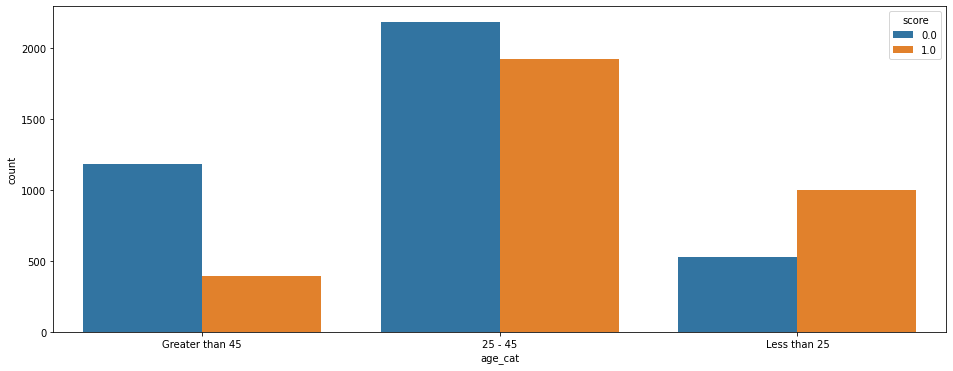

In [34]:
#score plot
plt.figure(figsize=(16,6))
by_age = sns.countplot(x="age_cat", hue="score", data=df_age[df_age.age_cat.isin(age_classes)])
print('Note: This plot takes the count per class into account.')

Just like before, while the COMPAS dataset has a likelihood between 0 and 10, this is reduced to binary (0 - low risk, 1 - medium-high risk).

  
As mentioned before, the people over the age of 45 (older) are given a lesser likelihood to reoffend, while persons under 25 are more likely or not given a medium to high recidivism risk. The age group in the middle, 25-45, is the closest call, only separated by a few more people being labeled as a low risk.


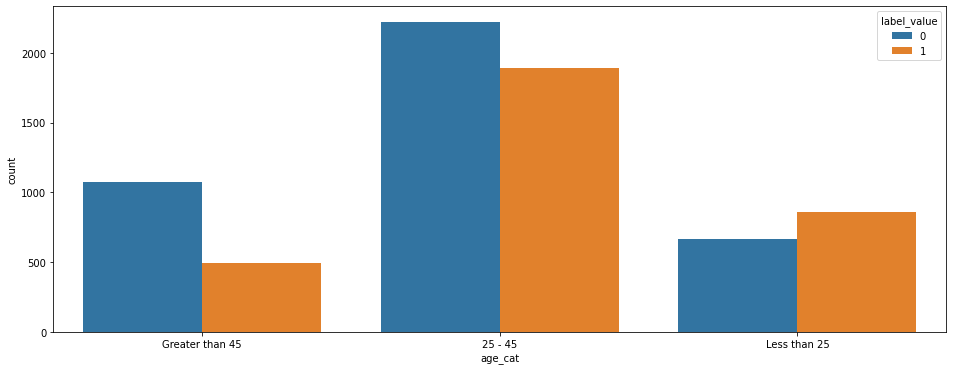

In [35]:
#level of recidivism plot
plt.figure(figsize=(16,6))
label_by_age = sns.countplot(x="age_cat", hue="label_value", data=df_age[df_age.age_cat.isin(age_classes)])

This plot shows the actual recidivism rates 2 years after release. While the prediction seems very accurate for the medium age group, a few more old people than predicted reoffned while the number of young people who reoffend is acually quite a lot lower than thought and predicted.

In [36]:
age = df_age['age_cat'].tolist()
score = df_age['score'].tolist()
recividism = df_race['label_value'].tolist()

def CountScoreClasses(age_classes, column):
  count = 0
  count2 = 0

  for i in range(len(df)):
    if age[i] == age_classes and column[i] == 1:
      count += 1
    elif age[i] == age_classes and column[i] == 0:
      count2 += 1

  return count, count2

In [37]:
#counting score per race
low_age = CountScoreClasses('Less than 25', score)
med_age = CountScoreClasses('25 - 45', score)
high_age = CountScoreClasses('Greater than 45', score)

In [38]:
#counting recividism per race
low_age_rec = CountScoreClasses('Less than 25', recividism)
med_age_rec = CountScoreClasses('25 - 45', recividism)
high_age_rec = CountScoreClasses('Greater than 45', recividism)


In [39]:
#prepare precentage df columns 
score1 = [low_age[0], med_age[0], high_age[0] ]
score0 = [low_age[1], med_age[1], high_age[1] ]

rec1 = [low_age_rec[0], med_age_rec[0], high_age_rec[0] ]
rec0 = [low_age_rec[1], med_age_rec[1], high_age_rec[1] ]

cols = {'age' : age_classes, 'score0' : score0, 'score1' : score1, 'rec0' : rec0, 'rec1' : rec1}
df_percent_age = pd.DataFrame(data=cols)

In [40]:
df_percent_age

,age,score0,score1,rec0,rec1
0,Greater than 45,530,999,813,716
1,25 - 45,2185,1924,2264,1845
2,Less than 25,1182,394,886,690


This chart shows the absolute numbers of actual reoffenders and predicted reoffenders, as well as those who actually stay out of prison and the predictions.

In [41]:
#calculate % of variables
percentage_sc0 = []
percentage_sc1 = []

percentage_rec0 = []
percentage_rec1 = []

for i in range(len(df_percent_age)):
  value_sc1 = (score1[i] * 100)/(score0[i] + score1[i])
  value_sc0 = (score0[i] * 100)/(score1[i] + score0[i])
  value_rec1 = (rec1[i] * 100)/(rec0[i] + rec1[i])
  value_rec0 = (rec0[i] * 100)/(rec1[i] + rec0[i])
  percentage_sc0.append(value_sc0)
  percentage_sc1.append(value_sc1)
  percentage_rec0.append(value_rec0)
  percentage_rec1.append(value_rec1)

df_percent_age['%_score0'] = percentage_sc0
df_percent_age['%_score1'] = percentage_sc1
df_percent_age['%_rec0'] = percentage_rec0
df_percent_age['%_rec1'] = percentage_rec1

df_percent_age

,age,score0,score1,rec0,rec1,%_score0,%_score1,%_rec0,%_rec1
0,Greater than 45,530,999,813,716,34.663179,65.336821,53.172008,46.827992
1,25 - 45,2185,1924,2264,1845,53.175955,46.824045,55.098564,44.901436
2,Less than 25,1182,394,886,690,75.000000,25.000000,56.218274,43.781726


This chart shows the relative numbers (percentages) of the dataset.

In [ ]:
#define df with variables to audit
g = Group()
xtab, _ = g.get_crosstabs(df_age)
absolute_metrics = g.list_absolute_metrics(xtab)

#indicators to take into account for further figures
metrics = ['fpr','fdr', 'fnr']
disparity_tolerance = 1.25

In [43]:
# Compute Group Counts bias metrics
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,0,binary 0/1,3317,age_cat,25 - 45,1924,2185,741,706,1479,1183,1889,2220,4109,7214
1,0,binary 0/1,3317,age_cat,Greater than 45,394,1182,181,285,897,213,498,1078,1576,7214
2,0,binary 0/1,3317,age_cat,Less than 25,999,530,360,225,305,639,864,665,1529,7214


In [44]:
# Group value bias metrics
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,age_cat,25 - 45,0.63,0.67,0.32,0.39,0.33,0.37,0.68,0.61,0.58,0.47,0.46
1,age_cat,Greater than 45,0.43,0.83,0.24,0.46,0.17,0.57,0.76,0.54,0.12,0.25,0.32
2,age_cat,Less than 25,0.74,0.46,0.42,0.36,0.54,0.26,0.58,0.64,0.30,0.65,0.57


## Bias and Faireness audit with Aequitas

In [46]:
#absolute metrics plot - reference Caucasian
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_age, 
                                        ref_groups_dict={'age_cat':'25 - 45'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)

ap.absolute(bdf, metrics, 'age_cat', fairness_threshold = disparity_tolerance)

get_disparity_predefined_group()


alt.LayerChart(...)

As a reference, the medium age category was chosen, since the predictions are quite close to reality here. The false positive and false negative rates deviate from those of the reference group by more than the selected threshold of 1.25. 

The false positive rate of young people deviates to the higher side, since more people than necissary are considered likely to reoffend. Similarly, the young people also have a lower false negative rate, meaning few actual offenders are missed in the prediction since more younger people than actually necessary are labeled as likely reoffenders.

In [47]:
#bias disparity 
#b = Bias()

#putting disparity to compare to Youngest
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_age, 
                                        ref_groups_dict={'age_cat':'25 - 45'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

get_disparity_predefined_group()


,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,age_cat,25 - 45,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
1,age_cat,Greater than 45,1.192804,1.531238,0.746232,0.503031,1.121136,0.204782,0.533914,0.879232,1.248989,0.682963,True,True,True,True,True,True,True,True,True,True,True,True
2,age_cat,Less than 25,0.935673,0.696781,1.313873,1.621868,0.850173,0.519231,1.395369,1.040293,0.688435,1.180958,True,True,False,True,True,False,True,True,True,False,False,True


In [48]:
#plotting disparities using the previous reference indicators
ap.disparity(bdf, metrics, 'age_cat', fairness_threshold = disparity_tolerance)

alt.LayerChart(...)

In [49]:
#Summary  - Parity Test
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)

Based on the previously set thresholf of 1.25 and the medium-aged reference group, both the FPR and FNR metrics fail the test. Only the False Discovery Rate passes the test. People labeled as reoffenders therefore fall within a 1.25 margin percentage of all those that actually reoffend.

In [50]:
# Attribute fairness - by age
f = Fairness()
fdf = f.get_group_value_fairness(bdf)

In [51]:
race_fairness = f.get_group_attribute_fairness(fdf)
race_fairness

,model_id,score_threshold,attribute_name,Statistical Parity,Impact Parity,FDR Parity,FPR Parity,FOR Parity,FNR Parity,TPR Parity,TNR Parity,NPV Parity,Precision Parity,TypeI Parity,TypeII Parity,Equalized Odds,Unsupervised Fairness,Supervised Fairness
0,0,binary 0/1,age_cat,False,False,True,False,False,False,False,False,True,True,False,False,False,False,False


In [52]:
overall_fair = f.get_overall_fairness(fdf)
overall_fair

{'Overall Fairness': False,
 'Supervised Fairness': False,
 'Unsupervised Fairness': False}

# Age - Conclusion
As per the workflow, the model fairness for the age category is very low and fails to meet the threshold of a difference of 1.25.

While we as a society agree that we should not treat people more harshly based on immutable, inheritly unfair characteristics such as race, occupation, wealth or gender, we seem to agree that age is not one of those factors. Since age affects every human in the same way and because it is known that certain age-groups are more likely to reoffend.

While it is clear that the diffenrent treatment of different age groups is acceptable, it still became clear that more young people are predicted to reoffend than actualy do so. While there might be serial offenders starting out on a path of career-criminalism, quite a high number of young people seemed to have learnt their lesson and do not reoffend. Therefore it might be advisable to be more cautious in some cases.